In [19]:
# imports

import pandas as pd
import numpy as np

import librosa
from IPython import display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import sklearn
from sklearn.preprocessing import minmax_scale
import os
import pathlib
import pickle

In [2]:
import spotipy
import spotipy.util

In [3]:
from bs4 import BeautifulSoup
import requests
import selenium
from selenium import webdriver

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score


In [5]:
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT


In [6]:
from bokeh.io import output_file, show, export_png
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn

In [7]:
#from flask_sqlalchemy import sqlalchemy
from sqlalchemy import create_engine

In [79]:
# checking path for imports that weren't working
import sys
sys.path

['/Users/local/anaconda3/envs/metis/lib/python36.zip',
 '/Users/local/anaconda3/envs/metis/lib/python3.6',
 '/Users/local/anaconda3/envs/metis/lib/python3.6/lib-dynload',
 '',
 '/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages',
 '/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/IPython/extensions',
 '/Users/local/.ipython']

In [31]:
# experimenting with audio analysis 
# done with help from https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8
audio_path = 'genres/classical/classical.00000.au'
x, sr = librosa.load(audio_path)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


In [32]:
ipd.Audio(audio_path)

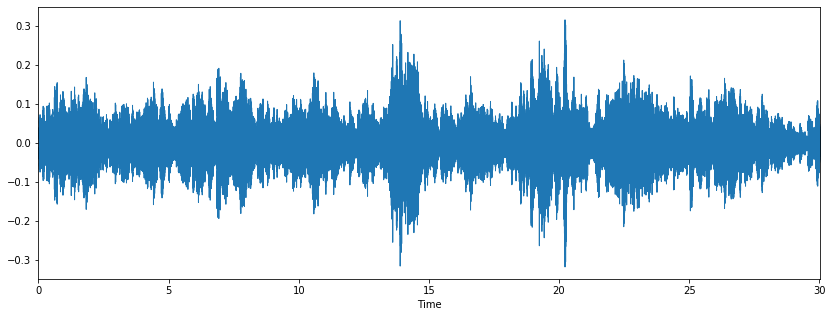

In [33]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(x, sr=sr)

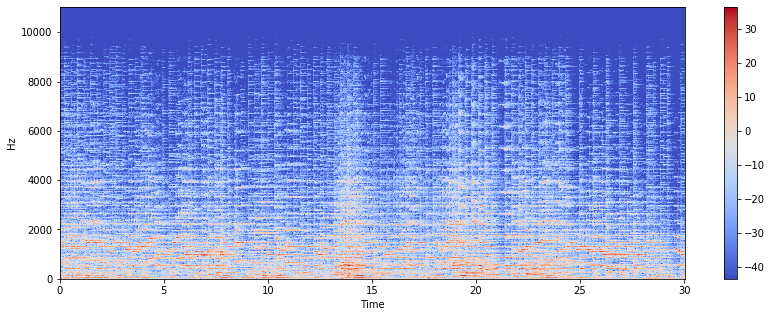

In [34]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

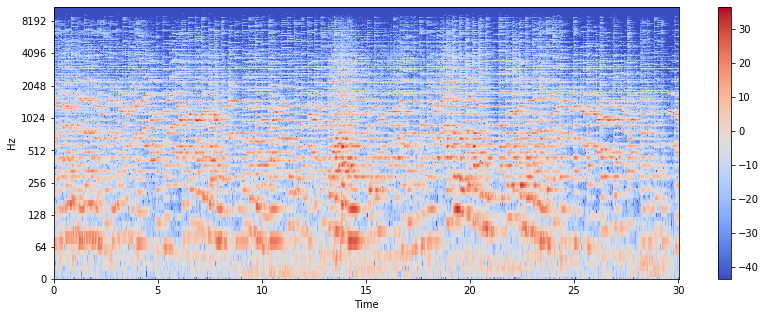

In [35]:
plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

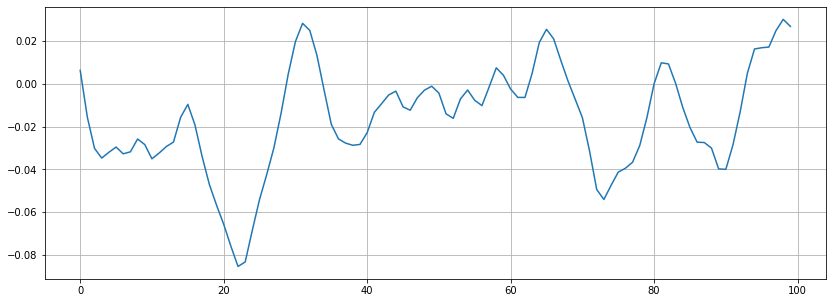

In [36]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [37]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

10


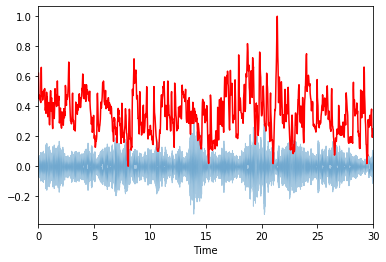

In [38]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]

frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

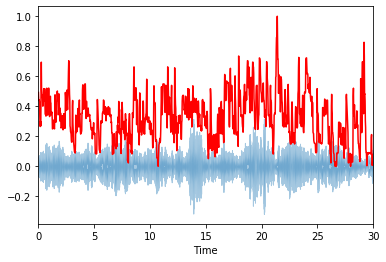

In [39]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

(20, 1293)


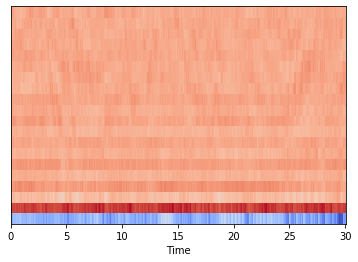

In [41]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

[ 9.2656869e-09  1.2630838e-08  1.2169858e-08 -1.8531374e-08
 -1.0786920e-08 -8.8508054e-09 -1.5673302e-09  2.0283097e-09
  3.1490659e-09  3.1669288e-08 -3.5725909e-09  5.5087046e-09
 -1.0141549e-09  1.6503066e-08 -4.1488151e-09  3.6878358e-09
  1.5673302e-09 -1.5581106e-08 -1.7033191e-08  1.7563318e-08]
[1.0000005  1.0000005  0.9999997  0.9999997  1.0000015  0.9999998
 0.9999998  1.         0.9999999  0.99999964 1.0000004  0.99999917
 1.0000008  1.0000002  0.9999997  0.9999998  1.         1.0000011
 1.0000015  1.000001  ]


/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


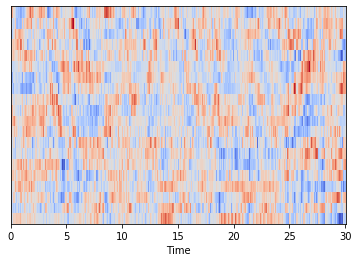

In [42]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')


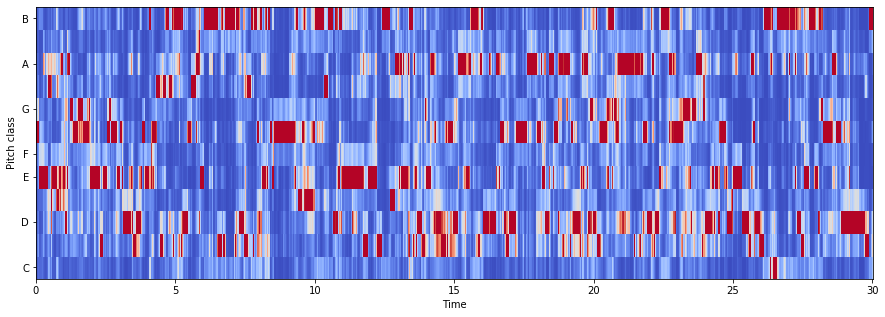

In [43]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

In [49]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()
plt.show()

/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7725: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 720x720 with 0 Axes>

Waveform analysis didn't end up getting used for the project unfortunately

# Data Gathering

In [87]:
# test spotipy

token = 'BQAacHlirKEbWX7YQVPG3B9M34D4s9sWWsnT2OrDL3jKEFIa3smwUw3Ei1UeWR107I11SruWgUn2oXF_PU85xoEJvGEdixpQshwOR81s_TUIVFBSLdCnk294_eiS9EG1gJLNnQNCLCidgejsHUDw3-JlpuB6Dty4'
sp = spotipy.Spotify(auth = token)
track_ids = sp.user_playlist_tracks('thesoundsofspotify', playlist_id='7qACZGMjyo64TdUdKAegjp', fields='items(track(id))')
#sp.audio_features(track_ids['items'][0]['track']['id'])

# get mp3 for track
#sp.track(track_ids['items'][0]['track']['id'])['preview_url']

# get audio features for track (can only do 50 at a time)
sp.audio_features(track_ids['items'][0]['track']['id'])
# we want: danceability, energy, key, loudness, mode (preferably feat engineer key and mode), speechiness, 
# acousticness, instrumentalness, liveness, valence, tempo
#for i in track_ids['items']:
#    print(i['track']['id'])

[{'danceability': 0.705,
  'energy': 0.483,
  'key': 1,
  'loudness': -12.209,
  'mode': 1,
  'speechiness': 0.0542,
  'acousticness': 0.15,
  'instrumentalness': 0.0265,
  'liveness': 0.202,
  'valence': 0.713,
  'tempo': 122.863,
  'type': 'audio_features',
  'id': '2Cg3GUkhjX96nO4p2WRlIa',
  'uri': 'spotify:track:2Cg3GUkhjX96nO4p2WRlIa',
  'track_href': 'https://api.spotify.com/v1/tracks/2Cg3GUkhjX96nO4p2WRlIa',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2Cg3GUkhjX96nO4p2WRlIa',
  'duration_ms': 181786,
  'time_signature': 4}]

Pull 100 songs each from 11 playlists, put data in a DataFrame

In [172]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock electronic'.split()

playlists = '''7qACZGMjyo64TdUdKAegjp 3HYK6ri0GkvRcM6GkKh0hJ 4mijVkpSXJziPiOrK7YX4M 0ZVSWcJIf7cvycEn9HUvps 
            6MXkE0uYF4XwU4VTtyrpfP 5EyFMotmvSfDAZ4hSdKrbx 3pBfUFu8MkyiCYyZe849Ks 6gS3HhOiI17QNojjPuPzqc 
            0TcXdt4sbITbwCwwFbKYyd 7dowgSWOmvdpwNkGFMUs6e 6I0NsYzfoj7yHXyvkZYoRx'''.split()

columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
           'liveness', 'valence', 'tempo', 'genre']

to_append = []

for g in zip(genres, playlists):
    
    # might need to check for request-after
    # get playlist for given genre
    track_ids = sp.user_playlist_tracks('thesoundsofspotify', playlist_id=g[1], fields='items(track(id))')
    # some lists for gathering data 
    tracks_list = []
    
    for track in track_ids['items']:
        tracks_list.append(track['track']['id'])
    
    # get audio features for 50 tracks at a time
    tracks_af = sp.audio_features(tracks_list[:50])
    for track_num in range(0, 50):
        track_data = []
        track_data.append(tracks_af[track_num]['danceability'])
        track_data.append(tracks_af[track_num]['energy'])
        track_data.append(tracks_af[track_num]['key'])
        track_data.append(tracks_af[track_num]['loudness'])
        track_data.append(tracks_af[track_num]['mode'])
        track_data.append(tracks_af[track_num]['speechiness'])
        track_data.append(tracks_af[track_num]['acousticness'])
        track_data.append(tracks_af[track_num]['instrumentalness'])
        track_data.append(tracks_af[track_num]['liveness'])
        track_data.append(tracks_af[track_num]['valence'])
        track_data.append(tracks_af[track_num]['tempo'])
        track_data.append(g[0])
        to_append.append(track_data)
    
    #tracks_sp = sp.tracks(tracks_list[50:])
    tracks_af = sp.audio_features(tracks_list[50:])
    for track_num in range(0, 50):
        track_data = []
        track_data.append(tracks_af[track_num]['danceability'])
        track_data.append(tracks_af[track_num]['energy'])
        track_data.append(tracks_af[track_num]['key'])
        track_data.append(tracks_af[track_num]['loudness'])
        track_data.append(tracks_af[track_num]['mode'])
        track_data.append(tracks_af[track_num]['speechiness'])
        track_data.append(tracks_af[track_num]['acousticness'])
        track_data.append(tracks_af[track_num]['instrumentalness'])
        track_data.append(tracks_af[track_num]['liveness'])
        track_data.append(tracks_af[track_num]['valence'])
        track_data.append(tracks_af[track_num]['tempo'])
        track_data.append(g[0])
        to_append.append(track_data)

audio_data = pd.DataFrame(to_append, columns=columns)
audio_data

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,0.705,0.483,1,-12.209,1,0.0542,0.150000,0.026500,0.2020,0.7130,122.863,blues
1,0.633,0.625,0,-10.951,1,0.0436,0.492000,0.000418,0.2040,0.8410,103.355,blues
2,0.294,0.611,2,-6.268,1,0.0348,0.022600,0.435000,0.1140,0.5670,178.191,blues
3,0.745,0.436,5,-9.617,0,0.0430,0.597000,0.021300,0.6100,0.7710,114.216,blues
4,0.582,0.302,9,-11.624,1,0.0353,0.947000,0.010700,0.0931,0.6420,94.288,blues
5,0.433,0.700,11,-8.197,1,0.1630,0.843000,0.324000,0.1020,0.8000,80.623,blues
6,0.682,0.586,7,-10.984,1,0.0959,0.346000,0.064800,0.0884,0.8650,118.567,blues
7,0.596,0.545,11,-8.913,0,0.0640,0.456000,0.000055,0.3290,0.7180,146.953,blues
8,0.676,0.334,5,-10.572,1,0.0508,0.862000,0.000000,0.3200,0.8670,158.000,blues
9,0.581,0.333,0,-14.209,1,0.0320,0.944000,0.472000,0.3320,0.4880,94.197,blues


In [173]:
audio_data.to_pickle('first_audio_data.pkl')

In [8]:
audio_data = pd.read_pickle('first_audio_data.pkl')



attempting to get mp3 file for each track, didn't work out

In [145]:
tracks_list = []
for track in track_ids['items']:
    tracks_list.append(track['track']['id'])
tracks = sp.tracks(tracks_list[:49])
#print(tracks)
#for track in tracks['tracks']:
#    print(track['preview_url'])
audio_path = tracks['tracks'][0]['preview_url'].split('/')[4].split('?')[0]+'.mp3'
x, sr = librosa.load(tracks['tracks'][0]['preview_url'])

FileNotFoundError: [Errno 2] No such file or directory: 'https://p.scdn.co/mp3-preview/76a319173677aa416718c3b253917fc966073b45?cid=774b29d4f13844c495f206cafdad9c86'

In [158]:
response = requests.get(tracks['tracks'][0]['preview_url'])
print(response.raw.)

b''


In [165]:
driver = webdriver.Chrome()
driver.get(tracks['tracks'][0]['preview_url'])
mp3 = driver.find_elements_by_xpath('//source')
print(mp3)

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=75.0.3770.142)
  (Driver info: chromedriver=2.38.552518 (183d19265345f54ce39cbb94cf81ba5f15905011),platform=Mac OS X 10.14.5 x86_64)


# Train/Test Splitting and Model Training

In [9]:
X_train, X_test, label_train, label_test = train_test_split(audio_data.drop('genre', axis=1), audio_data['genre'], \
                                                            test_size=0.2, random_state=112)

In [88]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, label_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, label_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, label_test)))

The score for kNN is
Training:  35.00%
Test set:  30.00%


In [95]:
logit = LogisticRegression(C = 0.95)
lrfit = logit.fit(X_train, label_train)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logit.score(X_train, label_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, label_test)))

The score for logistic regression is
Training:  58.64%
Test set:  58.18%


/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [68]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, label_train)
lda.score(X_test, label_test)

0.5681818181818182

In [182]:
audio_data.drop('genre', axis=1)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.705,0.483,1,-12.209,1,0.0542,0.150000,0.026500,0.2020,0.7130,122.863
1,0.633,0.625,0,-10.951,1,0.0436,0.492000,0.000418,0.2040,0.8410,103.355
2,0.294,0.611,2,-6.268,1,0.0348,0.022600,0.435000,0.1140,0.5670,178.191
3,0.745,0.436,5,-9.617,0,0.0430,0.597000,0.021300,0.6100,0.7710,114.216
4,0.582,0.302,9,-11.624,1,0.0353,0.947000,0.010700,0.0931,0.6420,94.288
5,0.433,0.700,11,-8.197,1,0.1630,0.843000,0.324000,0.1020,0.8000,80.623
6,0.682,0.586,7,-10.984,1,0.0959,0.346000,0.064800,0.0884,0.8650,118.567
7,0.596,0.545,11,-8.913,0,0.0640,0.456000,0.000055,0.3290,0.7180,146.953
8,0.676,0.334,5,-10.572,1,0.0508,0.862000,0.000000,0.3200,0.8670,158.000
9,0.581,0.333,0,-14.209,1,0.0320,0.944000,0.472000,0.3320,0.4880,94.197


In [200]:
(audio_data['tempo']-audio_data['tempo'].mean())/audio_data['tempo'].mean()

0       0.057317
1      -0.110562
2       0.533451
3      -0.017096
4      -0.188589
5      -0.306186
6       0.020347
7       0.264628
8       0.359694
9      -0.189373
10     -0.292339
11     -0.043661
12     -0.131009
13      0.314730
14     -0.043507
15     -0.312709
16      0.384651
17     -0.027681
18     -0.034324
19      0.018747
20     -0.360746
21      0.147247
22      0.257442
23      0.369333
24     -0.304912
25     -0.211274
26     -0.004454
27      0.090656
28     -0.161413
29     -0.245679
          ...   
1070   -0.105149
1071    0.411285
1072   -0.118763
1073    0.092902
1074    0.135853
1075    0.195929
1076    0.101516
1077   -0.004377
1078    0.444529
1079   -0.046303
1080    0.075820
1081    0.378266
1082    0.092239
1083    0.084322
1084   -0.242839
1085   -0.099762
1086    0.230455
1087    0.020451
1088    0.050226
1089    0.067670
1090    0.292174
1091    0.076353
1092    0.075716
1093   -0.208271
1094   -0.225542
1095   -0.018722
1096   -0.044832
1097   -0.0538

normalizing tempo to see if it helps results, more model training

In [79]:
audio_data_normalized = pd.read_pickle('first_audio_data.pkl')
audio_data_normalized['tempo'] = (audio_data_normalized['tempo']-audio_data_normalized['tempo'].mean())/audio_data_normalized['tempo'].mean()

In [80]:
audio_data_normalized.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,0.705,0.483,1,-12.209,1,0.0542,0.1500,0.026500,0.2020,0.713,0.057317,blues
1,0.633,0.625,0,-10.951,1,0.0436,0.4920,0.000418,0.2040,0.841,-0.110562,blues
2,0.294,0.611,2,-6.268,1,0.0348,0.0226,0.435000,0.1140,0.567,0.533451,blues
3,0.745,0.436,5,-9.617,0,0.0430,0.5970,0.021300,0.6100,0.771,-0.017096,blues
4,0.582,0.302,9,-11.624,1,0.0353,0.9470,0.010700,0.0931,0.642,-0.188589,blues


In [81]:
X_train2, X_test2, label_train2, label_test2 = train_test_split(audio_data_normalized.drop('genre', axis=1), audio_data_normalized['genre'], \
                                                            test_size=0.2, random_state=112)

In [84]:
knnN = KNeighborsClassifier(n_neighbors=15)
knnN.fit(X_train2, label_train2)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knnN.score(X_train2, label_train2)))
print("Test set: {:6.2f}%".format(100*knnN.score(X_test2, label_test2)))

The score for kNN is
Training:  41.70%
Test set:  25.45%


In [89]:
logitN = LogisticRegression(C = 0.95)
logitN.fit(X_train2, label_train2)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logitN.score(X_train2, label_train2)))
print("Test set: {:6.2f}%".format(100*logitN.score(X_test2, label_test2)))

The score for logistic regression is
Training:  57.95%
Test set:  56.36%


/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [74]:
logitMult = LogisticRegression(C = 0.95, multi_class='multinomial', solver='lbfgs')
logitMult.fit(X_train, label_train)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logitMult.score(X_train, label_train)))
print("Test set: {:6.2f}%".format(100*logitMult.score(X_test, label_test)))

The score for logistic regression is
Training:  39.09%
Test set:  31.82%


/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [92]:
X_train_mnb = X_train.drop('loudness', axis=1)
X_test_mnb = X_test.drop('loudness', axis=1)
mnb = MultinomialNB()
mnb.fit(X_train_mnb, label_train)
mnb.score(X_test_mnb, label_test)


0.3

In [78]:

nb = GaussianNB()
nb.fit(X_train, label_train)
nb.score(X_test, label_test)


0.5363636363636364

In [77]:

svm_model = svm.SVC(kernel="linear")
svm_model.fit(X_train, label_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [35]:
svm_model.score(X_test, label_test)

0.5409090909090909

In [10]:
decisiontree = DecisionTreeClassifier(max_depth=15)
decisiontree.fit(X_train, label_train)
decisiontree.score(X_test, label_test)

0.5181818181818182

In [20]:
audio_data = audio_data.drop(['mode', 'key'], axis=1)

In [24]:
X_train_fe, X_test_fe, label_train_fe, label_test_fe = train_test_split(audio_data.drop('genre', axis=1), audio_data['genre'], \
                                                            test_size=0.2, random_state=112)

In [17]:
randomforest = RandomForestClassifier(n_estimators=75)
randomforest.fit(X_train, label_train)
randomforest.score(X_test, label_test)

0.6363636363636364

In [89]:
randomforest_fe = RandomForestClassifier(n_estimators=75)
randomforest_fe.fit(X_train_fe, label_train_fe)
randomforest_fe.score(X_test_fe, label_test_fe)

0.6227272727272727

GridSearch for hyperparameters

In [71]:
gsdt = GridSearchCV(randomforest_fe, param_grid={'n_estimators':[1,75]})
gsdt.fit(X_train, label_train)
gsdt.score(X_test, label_test)

/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.5909090909090909

In [93]:
gsdt.scorer_

<function sklearn.metrics.scorer._passthrough_scorer(estimator, *args, **kwargs)>

In [97]:
gdtester = GridSearchCV(logit, param_grid={'C':[0.1,1]})
gdtester.fit(X_train, label_train)
gdtester.score(X_test, label_test)

/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/local/anaco

0.5863636363636363

In [101]:
gdtester.best_score_

0.5454545454545454

In [106]:
audio_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'genre'],
      dtype='object')

In [112]:
randomforest.feature_importances_

array([0.13636829, 0.10725576, 0.04080661, 0.10722268, 0.01678651,
       0.12755453, 0.1359151 , 0.10159589, 0.0561548 , 0.09477284,
       0.07556698])

# Data Visualization

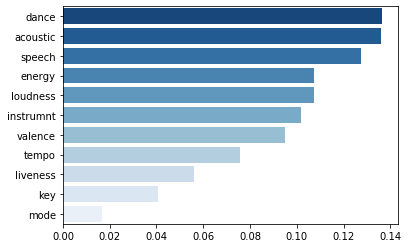

In [131]:
sns_plot = sns.barplot(y=['dance', 'energy', 'key', 'loudness', 'mode', 'speech',
       'acoustic', 'instrumnt', 'liveness', 'valence', 'tempo'], x=randomforest.feature_importances_,
                      palette='Blues_r', order=['dance', 'acoustic', 'speech','energy','loudness','instrumnt','valence','tempo','liveness','key','mode'])
sns_fig = sns_plot.get_figure()
sns_fig.savefig('feature_importance.png')

In [100]:
data = dict(
        models=['KNN', 'Log. Reg.', 'KNN (Norm tempo)', 'Log. Reg. (Norm tempo)',
                'LDA', 'Mult. Reg.', 'Mult. NB', 'Gauss. NB', 'SVM', 'Dec. Tree', 'Rand. Forest'],
        scores=['{:6.2f}%'.format(100*knn.score(X_test, label_test)), 
                '{:6.2f}%'.format(100*logit.score(X_test, label_test)),
                '{:6.2f}%'.format(100*knnN.score(X_test2, label_test2)),
                '{:6.2f}%'.format(100*logitN.score(X_test2, label_test2)), 
                '{:6.2f}%'.format(100*lda.score(X_test, label_test)), 
                '{:6.2f}%'.format(100*logitMult.score(X_test, label_test)),
                '{:6.2f}%'.format(100*mnb.score(X_test_mnb, label_test)), 
                '{:6.2f}%'.format(100*nb.score(X_test, label_test)), 
                '{:6.2f}%'.format(100*svm_model.score(X_test, label_test)),
                '{:6.2f}%'.format(100*decisiontree.score(X_test, label_test)), 
                '{:6.2f}%'.format(100*randomforest.score(X_test, label_test))],
    )
source = ColumnDataSource(data)

columns = [
        TableColumn(field="models", title="Models"),
        TableColumn(field="scores", title="Scores"),
    ]
data_table = DataTable(source=source, columns=columns, width=400, height=320)

show(data_table)

testing data uploading to  

In [69]:
params = {
    'host': '18.224.110.160',
    'user': 'ubuntu',
    'port': 5432
}

connection = connect(**params, dbname='ubuntu')
connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
connection.cursor().execute('CREATE DATABASE audio_data;')

In [85]:
connection_string = f'postgres://ubuntu:{params["host"]}@{params["host"]}:{params["port"]}/audio_data'
engine = create_engine(connection_string)
audio_data.to_sql('audio_data', engine, index=False)

In [86]:
connection = connect(**params, dbname='audio_data')
cursor = connection.cursor()
cursor.execute("SELECT * FROM audio_data;")
cursor.fetchall()

[(0.705,
  0.483,
  1,
  -12.209,
  1,
  0.0542,
  0.15,
  0.0265,
  0.202,
  0.713,
  122.863,
  'blues'),
 (0.633,
  0.625,
  0,
  -10.951,
  1,
  0.0436,
  0.492,
  0.000418,
  0.204,
  0.841,
  103.355,
  'blues'),
 (0.294,
  0.611,
  2,
  -6.268,
  1,
  0.0348,
  0.0226,
  0.435,
  0.114,
  0.567,
  178.191,
  'blues'),
 (0.745,
  0.436,
  5,
  -9.617,
  0,
  0.043,
  0.597,
  0.0213,
  0.61,
  0.771,
  114.216,
  'blues'),
 (0.582,
  0.302,
  9,
  -11.624,
  1,
  0.0353,
  0.947,
  0.0107,
  0.0931,
  0.642,
  94.288,
  'blues'),
 (0.433, 0.7, 11, -8.197, 1, 0.163, 0.843, 0.324, 0.102, 0.8, 80.623, 'blues'),
 (0.682,
  0.586,
  7,
  -10.984,
  1,
  0.0959,
  0.346,
  0.0648,
  0.0884,
  0.865,
  118.567,
  'blues'),
 (0.596,
  0.545,
  11,
  -8.913,
  0,
  0.064,
  0.456,
  5.53e-05,
  0.329,
  0.718,
  146.953,
  'blues'),
 (0.676,
  0.334,
  5,
  -10.572,
  1,
  0.0508,
  0.862,
  0.0,
  0.32,
  0.867,
  158.0,
  'blues'),
 (0.581,
  0.333,
  0,
  -14.209,
  1,
  0.032,
  0.944

In [121]:
# what the flask app is doing
from spotipy.oauth2 import SpotifyClientCredentials
#client_credentials_manager = SpotifyClientCredentials()
#app_sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

sp_search_query = sp.search(q="omae wa mou", type='track')
searched_song_uri = sp_search_query['tracks']['items'][0]['uri']
searched_song_features = sp.audio_features(searched_song_uri)[0]
relevant_feats = []
relevant_feats.append(searched_song_features['danceability'])
relevant_feats.append(searched_song_features['energy'])
relevant_feats.append(searched_song_features['key'])
relevant_feats.append(searched_song_features['loudness'])
relevant_feats.append(searched_song_features['mode'])
relevant_feats.append(searched_song_features['speechiness'])
relevant_feats.append(searched_song_features['acousticness'])
relevant_feats.append(searched_song_features['instrumentalness'])
relevant_feats.append(searched_song_features['liveness'])
relevant_feats.append(searched_song_features['valence'])
relevant_feats.append(searched_song_features['tempo'])
relevant_feats = np.array(relevant_feats).reshape(1,-1)
logit.predict(relevant_feats)

SpotifyException: http status: 401, code:-1 - https://api.spotify.com/v1/search?q=omae+wa+mou&limit=10&offset=0&type=track:
 The access token expired

In [102]:
import pickle
with open("lr.pkl", "wb") as f:
    pickle.dump(logit, f)

In [103]:
with open("dt.pkl", "wb") as f:
    pickle.dump(decisiontree, f)

In [20]:
with open("rf.pkl", "wb") as f:
    pickle.dump(randomforest, f)

In [112]:
np.array(relevant_feats).reshape(1,-1)

array([[ 7.42000e-01,  6.19000e-01,  1.00000e+00, -1.13700e+01,
         0.00000e+00,  5.17000e-02,  6.63000e-01,  7.07000e-01,
         1.25000e-01,  1.52000e-01,  1.26007e+02]])